In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pickle
import pyprind
import re
from PIL import Image
from IPython.core.display import Image as img
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from wordcloud import WordCloud, ImageColorGenerator
import math
from prettytable import PrettyTable as PT
from collections import Counter
import seaborn as sns
from scipy import spatial
import codecs

In [2]:
PATH_DATA = "V:/Programmazione/Amazon/"

In [3]:
df = pd.read_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

# Preproccessing of the data

In [4]:
def percent(value,tot):
    return value/float(tot)*100

## Filtering of categories with less then 1000 reviews

In [5]:
categories = sorted(df.product_category.unique().tolist())
tempCategories = []
delCategories = []
N = 1000 #inferior limit
for c in categories:
    if(df[df.product_category==c].count()[0])>=N:
        tempCategories.append(c)
    else:
        delCategories.append(c)
tot = df.count()[0]
NKeep = df[df['product_category'].isin(tempCategories)].count()[0]
NDisc = tot-NKeep
print("CATEGORIES KEEPED (%d): %s" % (len(tempCategories),", ".join(tempCategories)))
print("WE ARE KEEPING %d/%d (%.2f%%) REVIEWS" % (NKeep,tot,percent(NKeep,tot)))
print("\nCATEGORIES REMOVED (%d): %s" % (len(delCategories),", ".join(delCategories)))
print("WE ARE DISCARDING %d/%d (%.2f%%) REVIEWS" % (NDisc,tot,percent(NDisc,tot)))

CATEGORIES KEEPED (20): Baby, Books, Camera, Digital_Ebook_Purchase, Digital_Music_Purchase, Digital_Video_Download, Electronics, Home, Mobile_Apps, Music, Musical Instruments, PC, Shoes, Sports, Toys, Video, Video DVD, Video Games, Watches, Wireless
WE ARE KEEPING 1702443/1705765 (99.81%) REVIEWS

CATEGORIES REMOVED (13): Apparel, Automotive, Beauty, Health & Personal Care, Home Entertainment, Home Improvement, Kitchen, Lawn and Garden, Luggage, Office Products, Personal_Care_Appliances, Pet Products, Software
WE ARE DISCARDING 3322/1705765 (0.19%) REVIEWS


In [6]:
categories = tempCategories
df = df[df['product_category'].isin(categories)] #keep only the reviews of products contained into "survival" categories

## Deletion of stopwords from reviews' bodies and headlines

In [7]:
"""
Given a the a string the function return the tokenization of the string, a list which contain all the words transformed in lowercase
"""
def tokenize(text):
    return [t.lower() for t in nltk.word_tokenize(text) if(not bool(re.search(r"[^A-Za-z]", t)))]

In [8]:
STOPWORDS = set(stopwords.words('english')).union([u'br'])

In [9]:
"""
Given a the list of strings the function return a list which contain all the words of the reviews which:
1. are not stopwords
2. contain only letters
"""
def deleteStopwords(text):
    return [t for t in text if (t not in STOPWORDS)]

In [140]:
try:
    df_rev = pd.read_pickle("%sReviews.pkl" % PATH_DATA)
    df_rev_stop = pd.read_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA)
except IOError as I:
    df_rev = df.drop(["customer_id","product_id","product_title"], axis=1) #keep only the "interesting" columns
    df_rev["review_headline"] = df_rev["review_headline"].apply(func = tokenize) #apply the function deleteStopwords on headlines
    df_rev["review_body"] = df_rev["review_body"].apply(func = tokenize) #apply the function deleteStopwords on bodies
    df_rev.to_pickle("%sReviews.pkl" % PATH_DATA) #save the file
    df_rev_stop = df_rev.filter(df_rev.columns,axis=1)
    df_rev_stop["review_headline"] = df_rev_stop["review_headline"].apply(func = deleteStopwords) #apply the function deleteStopwords on headlines
    df_rev_stop["review_body"] = df_rev_stop["review_body"].apply(func = deleteStopwords) #apply the function deleteStopwords on bodies
    df_rev_stop.to_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA) #save the file

In [27]:
df_rev.head()

,product_category,star_rating,review_headline,review_body,review_date
review_id,,,,,
0,Music,5,"[five, stars]","[the, best, album, ever]",2014-12-29
1,Watches,4,"[great, watch, from, casio]","[what, a, great, watch, both, watches, and, st...",2013-10-24
2,Digital_Video_Download,5,[fantastic],"[love, watching, all, the, episodes, of, dexte...",2014-05-09
3,Toys,5,"[five, stars]","[excellent, game]",2014-09-19
4,Digital_Ebook_Purchase,5,"[a, twist, on, tales]","[this, cute, quick, read, is, very, different,...",2013-09-18


In [11]:
df_rev_stop.head()

,product_category,star_rating,review_headline,review_body,review_date
review_id,,,,,
0,Music,5,"[five, stars]","[best, album, ever]",2014-12-29
1,Watches,4,"[great, watch, casio]","[great, watch, watches, strap, great, quality,...",2013-10-24
2,Digital_Video_Download,5,[fantastic],"[love, watching, episodes, dexter, first, hear...",2014-05-09
3,Toys,5,"[five, stars]","[excellent, game]",2014-09-19
4,Digital_Ebook_Purchase,5,"[twist, tales]","[cute, quick, read, different, say, least, com...",2013-09-18


## Construction of "large" documents divided by categories/star ratings, body/headlines.

### Large document of categories' bodies and headlines

In [12]:
categories_reviews = {c:[] for c in categories}
categories_reviews_headlines = {c:[] for c in categories}

### Large document of star ratings' bodies and headlines

In [13]:
stars_body = {i:[] for i in range(1,6)}
stars_head = {i:[] for i in range(1,6)}

### Large document to keep al reviews without stopwords

In [14]:
all_reviews_without_stopwords = []

### Populate the structures

In [15]:
for index,row in df_rev_stop.iterrows():
    categories_reviews[row.product_category]+= row.review_body
    categories_reviews_headlines[row.product_category]+= row.review_headline
    stars_body[row.star_rating]+=row.review_body
    stars_head[row.star_rating]+=row.review_headline

In [16]:
for i in range(1,6):
    all_reviews_without_stopwords+=stars_head[i]+stars_body[i]

# Stats on test

### Number of reviews

In [17]:
t = PT(['Category', 'Number of reviews','% respect to the total'])
tot = float(df_rev.count()[0])
for c in categories:
    count = df_rev[df_rev.product_category==c].count()[0]
    t.add_row([c,count,"%.2f%%" % percent(count,tot)])
t.align["Category"] = 'l'
print("Number of total reviews = %.0f" % tot)
print(t.get_string(title="Number of reviews divided by category"))

Number of total reviews = 1702443
+------------------------+-------------------+------------------------+
| Category               | Number of reviews | % respect to the total |
+------------------------+-------------------+------------------------+
| Baby                   |        4328       |         0.25%          |
| Books                  |       257793      |         15.14%         |
| Camera                 |        6427       |         0.38%          |
| Digital_Ebook_Purchase |       289111      |         16.98%         |
| Digital_Music_Purchase |       29263       |         1.72%          |
| Digital_Video_Download |       31420       |         1.85%          |
| Electronics            |        5846       |         0.34%          |
| Home                   |        2690       |         0.16%          |
| Mobile_Apps            |       218031      |         12.81%         |
| Music                  |       329854      |         19.38%         |
| Musical Instruments    |    

In [18]:
t = PT(['Stars', 'Number of reviews','% respect to the total'])
for i in range(1,6):
    count = df_rev[df_rev.star_rating==i].count()[0]
    t.add_row(['*'*i,count,"%.2f%%" % percent(count,tot)])
print("Number of total reviews = %.0f" % tot)
print(t.get_string(title="Number of reviews divided by rating value"))

Number of total reviews = 1702443
+-------+-------------------+------------------------+
| Stars | Number of reviews | % respect to the total |
+-------+-------------------+------------------------+
|   *   |       84270       |         4.95%          |
|   **  |       58966       |         3.46%          |
|  ***  |       125421      |         7.37%          |
|  **** |       290995      |         17.09%         |
| ***** |      1142791      |         67.13%         |
+-------+-------------------+------------------------+


## Words Counts

### Categories' table

In [19]:
t = PT(['Category', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
tot = 0
for c in categories:
    rows = df_rev[df_rev['product_category']==c]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(categories_reviews[c])
    head_stop = len(categories_reviews_headlines[c])
    t.add_row([c,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    tot+=body_tot+head_tot
    rows = None
print("Number of words (headline+body) of all reviews = %d, without stopwords = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
t.align["Category"] = 'l'
print(t.get_string(title="Number of words divided by category"))

Number of words (headline+body) of all reviews = 116006962, without stopwords = 58563321, % deleted = 49.52%
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Category               |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Baby                   |  213963  |     101372     |   52.62%   |  15536   |       10776        |     30.64%     |
| Books                  | 24020191 |    11604672    |   51.69%   | 1070932  |       705427       |     34.13%     |
| Camera                 |  425321  |     207691     |   51.17%   |  24989   |       17380        |     30.45%     |
| Digital_Ebook_Purchase | 12974492 |    6337738     |   51.15%   |  996553  |       683756       |     31.39%     |
| Digital_Music_Purchase | 1242343  |     618370     |   50.23%   |  957

### Rating stars' table

In [20]:
t = PT(['Stars', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
for i in range(1,6):
    rows = df_rev[df_rev['star_rating']==i]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(stars_body[i])
    head_stop = len(stars_head[i])
    t.add_row(['*'*i,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    rows = None
print("Number of words (headline+body) of all reviews = %d, without stopwords = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
print(t.get_string(title="Number of words divided by rating value"))

Number of words (headline+body) of all reviews = 116006962, without stopwords = 58563321, % deleted = 49.52%
+-------+----------+----------------+------------+----------+--------------------+----------------+
| Stars |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+-------+----------+----------------+------------+----------+--------------------+----------------+
|   *   | 6488934  |    3127289     |   51.81%   |  326437  |       207421       |     36.46%     |
|   **  | 5988584  |    2887129     |   51.79%   |  241294  |       148288       |     38.54%     |
|  ***  | 11422048 |    5525299     |   51.63%   |  510611  |       322061       |     36.93%     |
|  **** | 23176603 |    11442578    |   50.63%   | 1080321  |       744226       |     31.11%     |
| ***** | 62979109 |    31429055    |   50.10%   | 3793021  |      2729975       |     28.03%     |
+-------+----------+----------------+------------+----------+--------------------+---------

### Categories' graphs

In [ ]:
def plotFreq(list_words,title):
    fr = nltk.FreqDist(list_words)
    plt.rcParams["figure.figsize"] = (20, 6)
    plt.title(title, fontsize = 15)
    fr.plot(20)

In [ ]:
for c in categories:
    plotFreq(categories_reviews[c]+categories_reviews_headlines[c],"Category: %s (body+headline)" % c)
    plt.show()

In [ ]:
for i in range(1,6):
    plotFreq(stars_body[i]+stars_head[i],"%d Stars: %s (body+headline)" % (i,"*"*i))
    plt.show()

### Lexical diversity

In [24]:
def lexical_diversity(text):
    return len(text)/len(set(text))

### Adjectives, Noun, verbs

In [25]:
t = PT(['Category', 'Body', 'Headline'])
t.get_string(title="Lexical diversity")
for c in categories:
    t.add_row([c,lexical_diversity(categories_reviews[c]),lexical_diversity(categories_reviews_headlines[c])])
t.align["Category"] = 'l'
print(t)

+------------------------+------+----------+
| Category               | Body | Headline |
+------------------------+------+----------+
| Baby                   |  14  |    6     |
| Books                  |  93  |    25    |
| Camera                 |  17  |    7     |
| Digital_Ebook_Purchase |  86  |    32    |
| Digital_Music_Purchase |  22  |    9     |
| Digital_Video_Download |  17  |    11    |
| Electronics            |  16  |    6     |
| Home                   |  7   |    4     |
| Mobile_Apps            |  64  |    25    |
| Music                  |  95  |    28    |
| Musical Instruments    |  11  |    4     |
| PC                     |  25  |    10    |
| Shoes                  |  8   |    4     |
| Sports                 |  9   |    4     |
| Toys                   |  24  |    12    |
| Video                  |  11  |    3     |
| Video DVD              | 105  |    33    |
| Video Games            |  12  |    4     |
| Watches                |  11  |    6     |
| Wireless

## Tags

In [28]:
def getStatsTags(listString):
    count = [0,0,0,0]
    for word,tag in nltk.pos_tag(listString,tagset="universal"):
        if(tag==u'ADJ'):
            count[0]+=1
        elif(tag==u'NOUN'):
            count[1]+=1
        elif(tag==u'VERB'):
            count[2]+=1
        else:
            count[3]+=1
    total = sum(count)
    return {u'ADJ':percent(count[0],total), u'NOUN':percent(count[1],total),u'VERB':percent(count[2],total),u'OTHER':percent(count[3],total)}

In [30]:
tags_head = dict()
for c in categories:
    tags_head[c] =  getStatsTags(categories_reviews_headlines[c])

In [31]:
tags_body = dict()
for c in categories:
    tags_body[c] =  getStatsTags(categories_reviews[c])

In [32]:
data_head = [[],[],[],[]]
data_body = [[],[],[],[]]
for i,tag in enumerate([u'ADJ',u'NOUN',u'VERB',u'OTHER']):
    for c in categories:
        data_head[i].append(tags_head[c][tag])
        data_body[i].append(tags_body[c][tag])

In [174]:
def plotTags(title, data):
    plt.rcParams["figure.figsize"] = (20, 10)
    adj = plt.bar(categories, data[0],color="#0E7C7B")
    noun = plt.bar(categories, data[1],bottom=data[0],color="#17BEBB")
    verb = plt.bar(categories, data[2],bottom=[x + y for x, y in zip(data[0], data[1])],color="#D4F4DD")
    other = plt.bar(categories, data[3],bottom=[x + y + z for x, y, z in zip(data[0], data[1],data[2])],color="#D62246")
    plt.ylabel('Percentage')
    plt.xlabel('Categories')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend((adj[0], noun[0], verb[0],other[0]), ('Adjectives', 'Nouns','Verbs','Others'),bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

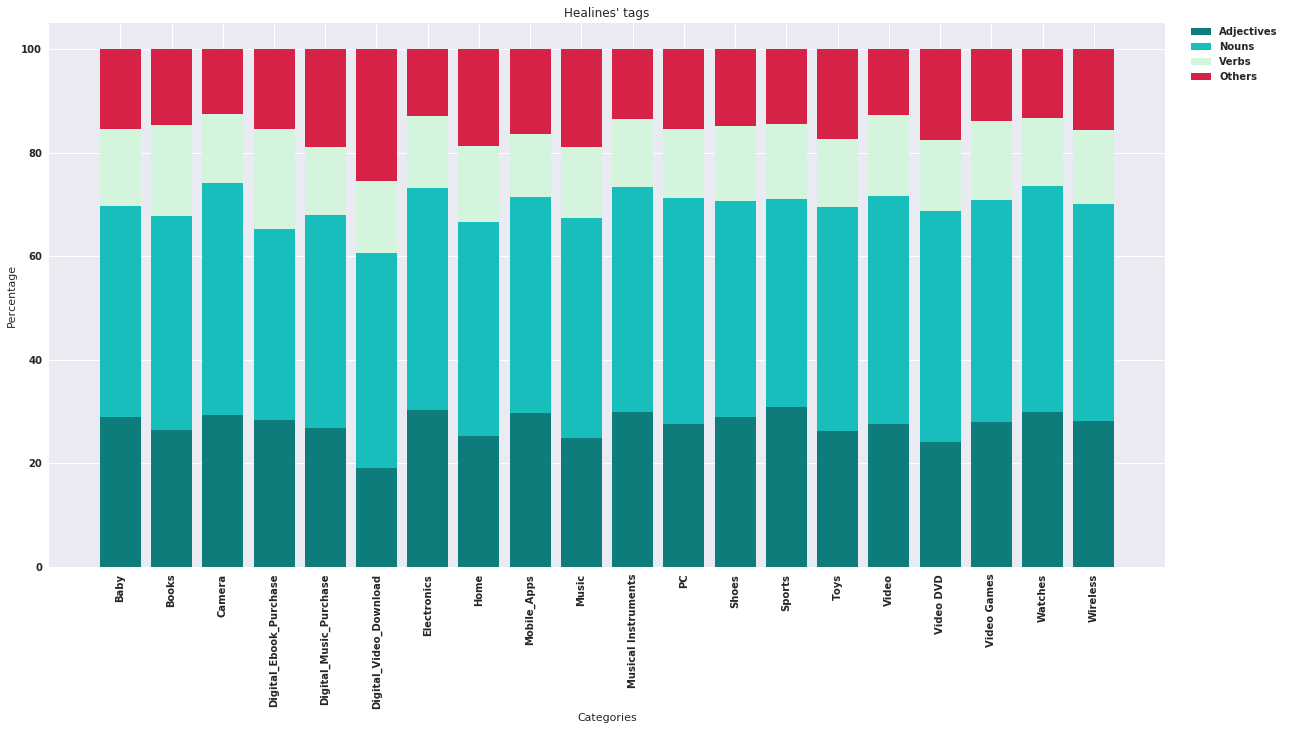

In [175]:
plotTags("Healines' tags",data_head)

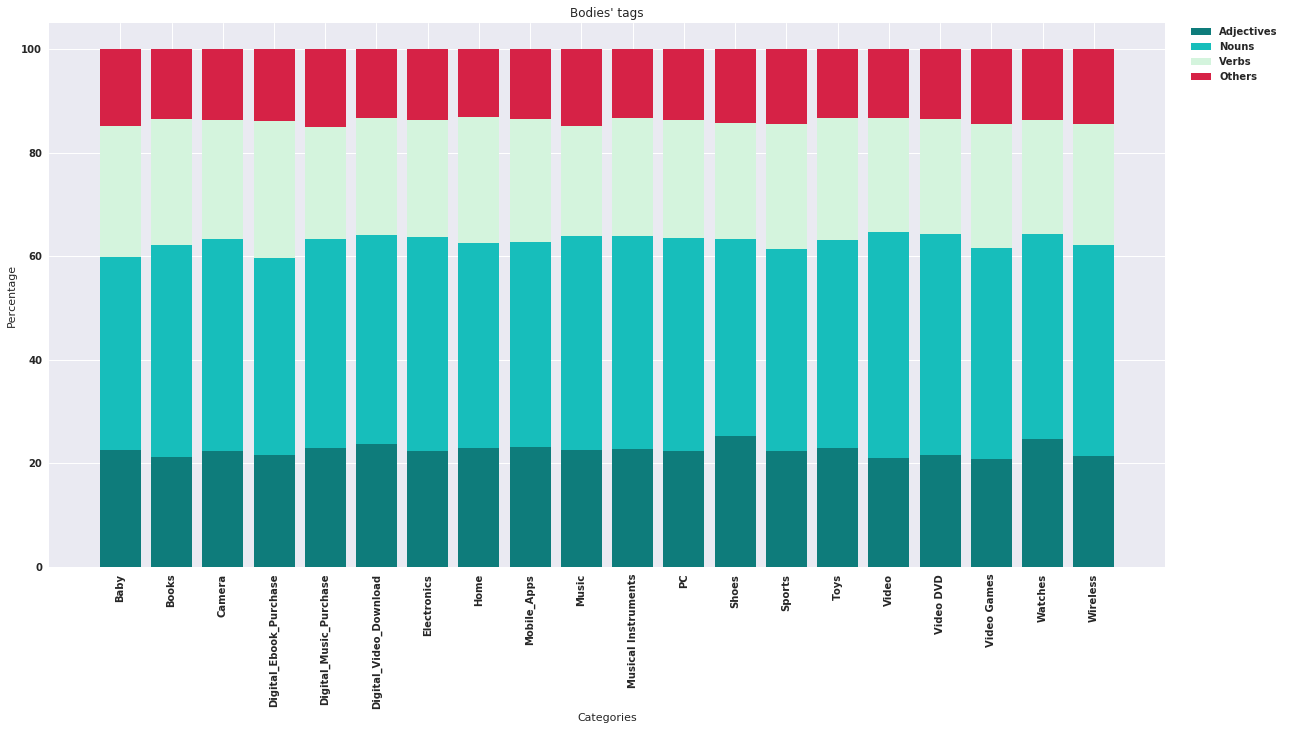

In [176]:
plotTags("Bodies' tags",data_body)

# Collocations

## Categories

### Bigrams (body+headline) with stopwords

In [36]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [37]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    res = []
    for index,row in df_rev[df_rev.product_category==c].iterrows():
        res += row.review_body+row.review_headline
    finder = BigramCollocationFinder.from_words(res)
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = list(finder.nbest(bigram_measures.pmi, 4))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2],res[3]])
t.align["Category"] = 'l'
print(t)

+--------------------------+----------------------+--------------------------+--------------------+-------------------+
| Category (body+headline) |         1st          |           2nd            |        3rd         |        4th        |
+--------------------------+----------------------+--------------------------+--------------------+-------------------+
|           Baby           |      cosi mura       |         lip balm         |     maxi cosi      |    silver cross   |
|          Books           |    baader meinhof    |       bani tihama        |   bhagavad gita    | crusonis annalium |
|          Camera          |     newton ellis     |        swan dice         |    casio exilim    |    iacute pode    |
|  Digital_Ebook_Purchase  |   amet consectetur   |    blaenau ffestiniog    | celaena sardothien |  charlize theron  |
|  Digital_Music_Purchase  |   aretha franklin    |       dimmu borgir       |   helter skelter   |    idina menzel   |
|  Digital_Video_Download  |     aldis h

### Bigrams (body+headline) without stopwords

In [38]:
bigramTable = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
bigramResult = []
for c in categories:
    finder = BigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = list(finder.nbest(bigram_measures.pmi, 30))
    res = [" ".join(r) for r in res]
    bigramResult+=res
    bigramTable.add_row([c,res[0],res[1],res[2],res[3]])
bigramTable.align["Category"] = 'l'
print(bigramTable)

+--------------------------+----------------------+--------------------------+--------------------+--------------------+
| Category (body+headline) |         1st          |           2nd            |        3rd         |        4th         |
+--------------------------+----------------------+--------------------------+--------------------+--------------------+
|           Baby           |      cosi mura       |         lip balm         |     maxi cosi      |    silver cross    |
|          Books           |    baader meinhof    |       bani tihama        |   bhagavad gita    | crusonis annalium  |
|          Camera          |     newton ellis     |        swan dice         |    casio exilim    |    iacute pode     |
|  Digital_Ebook_Purchase  |    aliquam lacus     |     amet consectetur     | blaenau ffestiniog | celaena sardothien |
|  Digital_Music_Purchase  |   aretha franklin    |       dimmu borgir       |   helter skelter   |    idina menzel    |
|  Digital_Video_Download  |    

### Trigrams (body+headline) with stopwords

In [39]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [40]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    res = []
    for index,row in df_rev[df_rev.product_category==c].iterrows():
        res += row.review_body+row.review_headline
    finder3 = TrigramCollocationFinder.from_words(res)
    finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = list(finder3.nbest(trigram_measures.pmi, 3))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2]])
t.align["Category"] = 'l'
print(t)

+--------------------------+------------------------------------+---------------------------------+--------------------------------+
| Category (body+headline) |                1st                 |               2nd               |              3rd               |
+--------------------------+------------------------------------+---------------------------------+--------------------------------+
|           Baby           |           maxi cosi mura           |       micro usb connector       |       maclaren techno xt       |
|          Books           |      pericla navarchi magonis      |    rebilii crusonis annalium    |       zaidi bani tihama        |
|          Camera          |           tr iacute pode           |           bla bla bla           |        lite tite swivel        |
|  Digital_Ebook_Purchase  |     lacus vivamus ullamcorper      |        lorem ipsum dolor        |  amet consectetur adipiscing   |
|  Digital_Music_Purchase  |  legal loopholes notwithstanding   |    

### Trigrams (body+headline) without stopwords

In [41]:
trigramTable = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
trigramResult = []
for c in categories:
    finder3 = TrigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = list(finder3.nbest(trigram_measures.pmi, 30))
    res = [" ".join(r) for r in res]
    trigramResult+=res
    trigramTable.add_row([c,res[0],res[1],res[2]])
trigramTable.align["Category"] = 'l'
print(trigramTable)

+--------------------------+----------------------------------+------------------------------+---------------------------------+
| Category (body+headline) |               1st                |             2nd              |               3rd               |
+--------------------------+----------------------------------+------------------------------+---------------------------------+
|           Baby           |          maxi cosi mura          |     micro usb connector      |        maclaren techno xt       |
|          Books           |     pericla navarchi magonis     |  rebilii crusonis annalium   |        zaidi bani tihama        |
|          Camera          |          tr iacute pode          |         bla bla bla          |         lite tite swivel        |
|  Digital_Ebook_Purchase  |      aliquam lacus vivamus       |  lacus vivamus ullamcorper   |        lorem ipsum dolor        |
|  Digital_Music_Purchase  | legal loopholes notwithstanding  |    taxes legal loopholes     |   

We would keep the collocations as they are in the following analysis. Therefore, we are going to change the structure in which are saved our text.

In [42]:
collocations = trigramResult+bigramResult

In [114]:
def searchCollocationStructure(collocations):
    a = {}#Structure to speed the research of bigrams and trigrams
    for coll in collocations:
        split = coll.split(" ")
        a.setdefault(split[0],{})
        a[split[0]].setdefault(split[1],set())
        if(len(split)==3):
            a[split[0]][split[1]].add(split[2])
        else:
            a[split[0]][split[1]].add(None)
    return a

In [115]:
def changeInCollocations(listWords,structure):
    i = 0
    newList = []
    while(i<len(listWords)):
        find = False
        one = listWords[i]
        if(one in structure and i+1<len(listWords)):#the first word appears among the first words of the collocations
            two = listWords[i+1]
            if(two in structure[one]):#the second word appears among the second words of the collocations
                if(i+2<len(listWords) and listWords[i+2] in structure[one][two]):#the third word appears among the third words of the collocations
                    newList.append("_".join([one,two,listWords[i+2]]))
                    i+=3
                    find = True
                elif(None in structure[one][two]):
                    newList.append("_".join([one,two]))
                    i+=2
                    find = True    
        if(not find):
            newList.append(one)
            i+=1
    return newList

In [116]:
structure = searchCollocationStructure(collocations)

In [117]:
print("Example: ['technically', 'truer', 'ethos','house','cosi', 'mura'] -> ['%s'] " % "', '".join(changeInCollocations([u'technically', u'truer', u'ethos',u'house',u'cosi',u'mura'],structure)))

Example: ['technically', 'truer', 'ethos','house','cosi', 'mura'] -> ['technically_truer_ethos', 'house', 'cosi_mura'] 


### Processing of the structure to change keep the collocations

In [141]:
df_rev_stop["review_headline"] = df_rev_stop["review_headline"].apply(func = changeInCollocations,args=([structure]))
df_rev_stop["review_body"] = df_rev_stop["review_body"].apply(func = changeInCollocations,args=([structure]))
df_rev["review_body"] = df_rev["review_body"].apply(func = changeInCollocations,args=([structure]))
df_rev["review_headline"] = df_rev["review_headline"].apply(func = changeInCollocations,args=([structure]))

In [125]:
categories_reviews = {c:[] for c in categories}
categories_reviews_headlines = {c:[] for c in categories}

In [126]:
stars_body = {i:[] for i in range(1,6)}
stars_head = {i:[] for i in range(1,6)}

In [127]:
all_reviews_without_stopwords = []

In [128]:
for index,row in df_rev_stop.iterrows():
    categories_reviews[row.product_category]+= row.review_body
    categories_reviews_headlines[row.product_category]+= row.review_headline
    stars_body[row.star_rating]+=row.review_body
    stars_head[row.star_rating]+=row.review_headline

In [129]:
for i in range(1,6):
    all_reviews_without_stopwords+=stars_head[i]+stars_body[i]

# Common words vs TF_IDF

### Functions

In [48]:
def tfIdf(fdistList):
    N_DOCUMENTS = len(fdistList)
    print("Total number of documents = %d" % N_DOCUMENTS)
    vocab = set()
    print("I'm creating the dictionary")
    for fdist in fdistList.values():
        vocab = vocab.union(set(fdist.keys()))#all words presents in all the documents
    idf = dict()
    print("I'm calculating the IDF")
    for word in vocab:
        count = 0.0
        for fdist in fdistList.values():
            if(word in fdist):
                count+=1
        idf[word] = math.log(N_DOCUMENTS/count)
    listTfIdf = dict()
    print("I'm calculating the tf-idf")
    i = 0
    for title, fdist in fdistList.items():
        listTfIdf[title] = dict()
        n_token_document = float(sum(fdist.values()))
        for word in fdist:
            listTfIdf[title][word] = fdist[word] * idf[word] /  n_token_document
        i+=1
    print("I have finished")
    return listTfIdf

In [49]:
#Function to draw the wordcloud
def make_word_cloud(dictWords, mask_path=None, background_color = "white", max_words = 2000, title = "", mux = 1, subplots_params = (1,1,1)):
    if(max_words>len(dictWords)):
        max_words = len(dictWords)
    topK = sorted(dictWords.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:max_words]
    text =[] 
    for word, value in topK:
        text+=[word]*int(round(value*mux))
    text = " ".join(text)
    if(mask_path!=None):
        # read the mask image
        mask = np.array(Image.open(mask_path))
        wc = WordCloud(background_color = background_color, max_words = max_words,  mask = mask, stopwords = None, collocations = False, max_font_size = 120)
        
    else:
        wc = WordCloud(background_color = background_color, max_words = max_words, stopwords = None, collocations = False, max_font_size = 120)
    # generate word cloud
    wc.generate(text)
    if(mask_path!=None):
        wc.recolor(color_func=ImageColorGenerator(mask))
    # store to file
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.subplot(subplots_params[0], subplots_params[1], subplots_params[2])
    plt.title(title, fontsize = 15)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")

### Calculations of most common words 

Draw wordlcloud taking into account all the categories (body+headline)

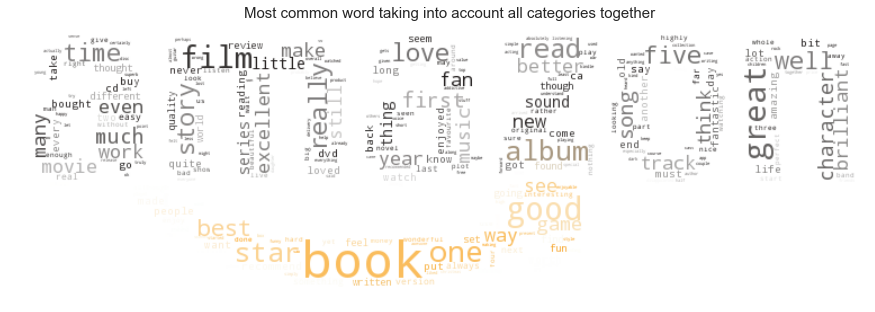

In [50]:
freq = nltk.FreqDist(all_reviews_without_stopwords)
make_word_cloud({v:k for v,k in freq.most_common(300)}, max_words = 300, title = "Most common word taking into account all categories together", mask_path = "ImagesWordClouds/amazon.jpg")
plt.show()

### Calculation of most important words based on the TF-IDF for each category

In [51]:
freq_dist_categories = dict()
for c in categories:
    freq_dist_categories[c] = nltk.FreqDist(categories_reviews[c]+categories_reviews_headlines[c])

In [52]:
listTfIdf_categories = tfIdf(freq_dist_categories)

Total number of documents = 20
I'm creating the dictionary
I'm calculating the IDF
I'm calculating the tf-idf
I have finished


### Differences between Most common and TF-IDF words

Print the differences between them (body+headline)

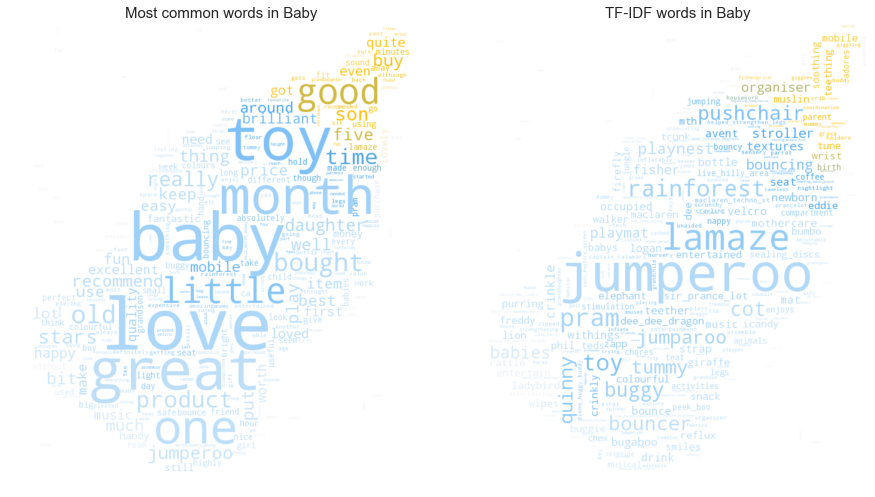

<Figure size 1080x720 with 0 Axes>

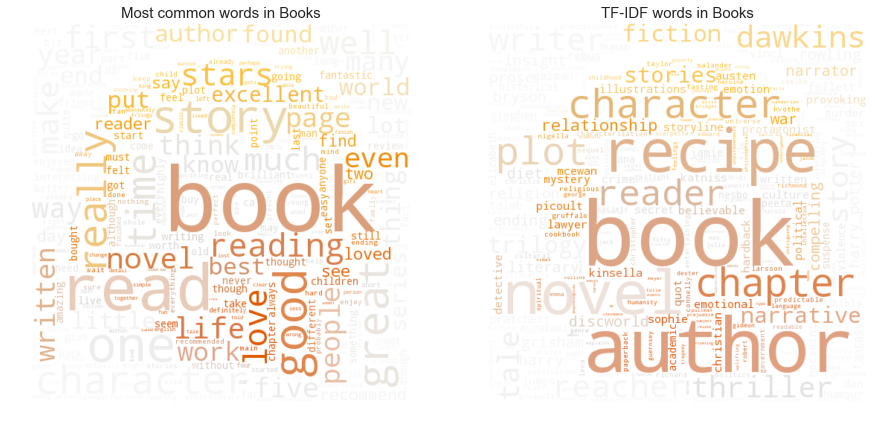

<Figure size 1080x720 with 0 Axes>

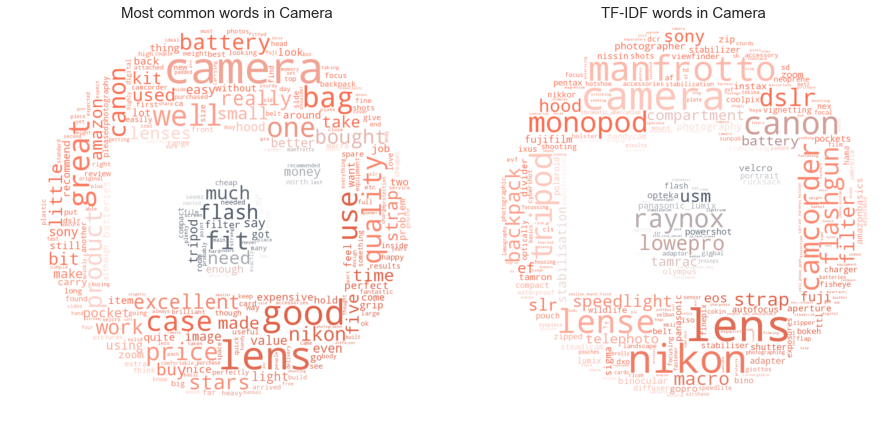

<Figure size 1080x720 with 0 Axes>

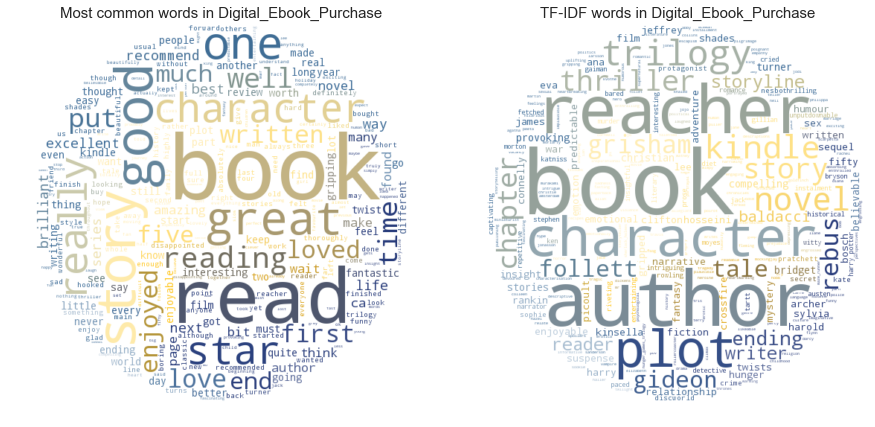

<Figure size 1080x720 with 0 Axes>

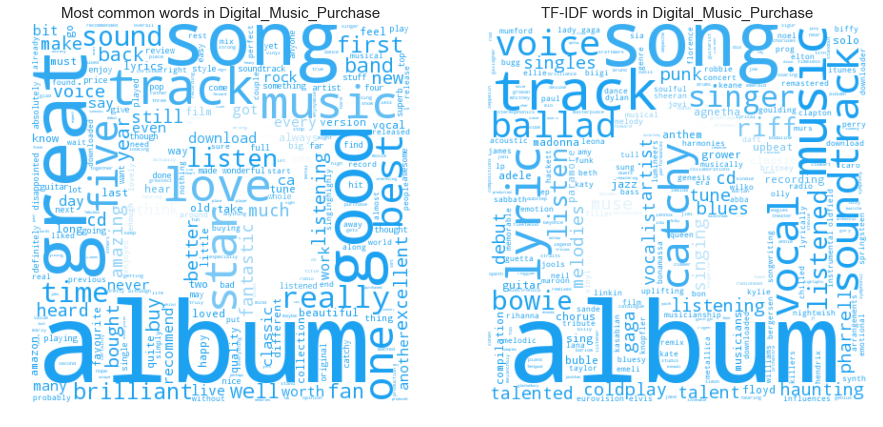

<Figure size 1080x720 with 0 Axes>

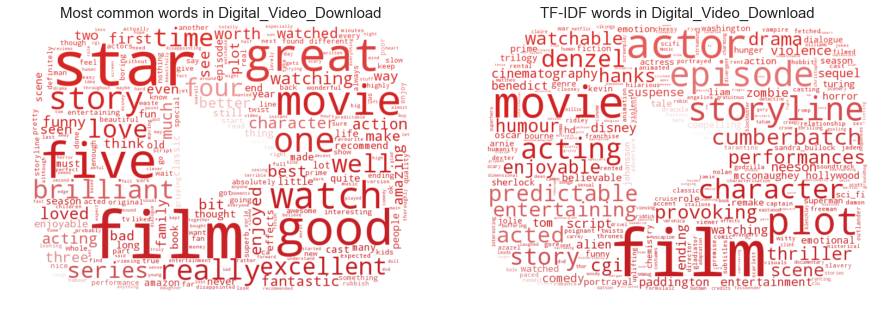

<Figure size 1080x720 with 0 Axes>

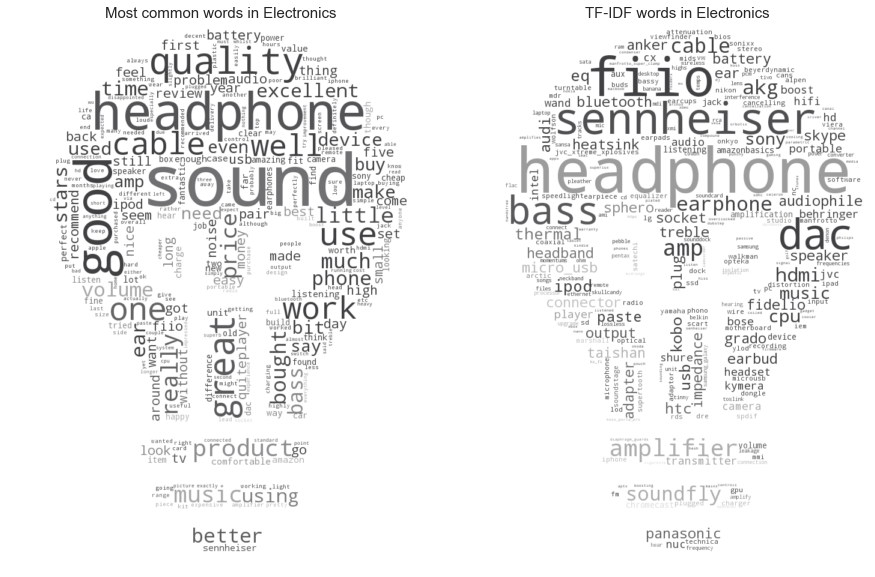

<Figure size 1080x720 with 0 Axes>

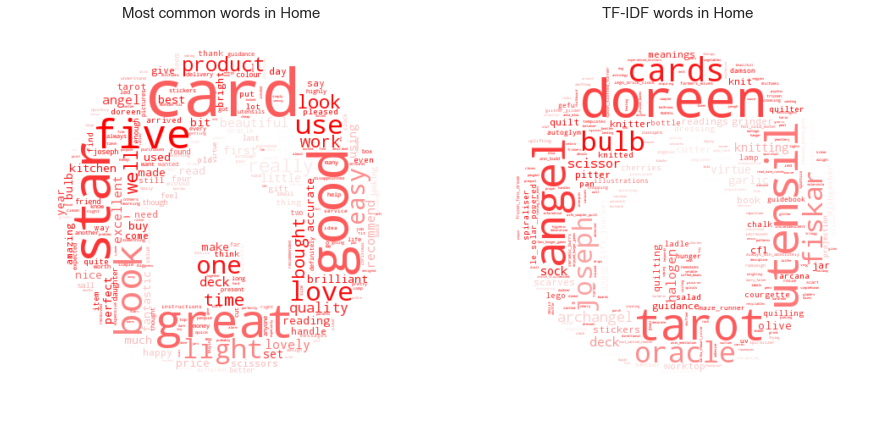

<Figure size 1080x720 with 0 Axes>

KeyboardInterrupt: 

In [53]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud({v:k for v,k in freq_dist_categories[c].most_common(n)}, max_words = n, title = "Most common words in %s" % c, mask_path = "ImagesWordClouds/%s.jpg" % c,subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_categories[c], max_words = n, title = "TF-IDF words in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## TF-IDF body vs TF-IDF headline

In [ ]:
freq_dist_categories_bodies = dict()
for c in categories:
    freq_dist_categories_bodies[c] = nltk.FreqDist(categories_reviews[c])

In [ ]:
listTfIdf_bodies = tfIdf(freq_dist_categories_bodies)

In [ ]:
freq_dist_categories_headlines = dict()
for c in categories:
    freq_dist_categories_headlines[c] = nltk.FreqDist(categories_reviews_headlines[c])

In [ ]:
listTfIdf_headlines = tfIdf(freq_dist_categories_headlines)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud(listTfIdf_bodies[c], max_words = n, title = "TF-IDF body in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_headlines[c], max_words = n, title = "TF-IDF headlline in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## Words based on the star_rating

We expect to find words which has a sentiment value based on the star rating. For example, for the reviews of 1 start, we expect to find: "bad, worst..". Moreover, we forcast to have better more interesting results using the most common words approach compare to the tf-idf.

### Looking at the reviews' body

In [80]:
freq_dist_stars_body = dict()
for i in range(1,6):
    freq_dist_stars_body[i] = nltk.FreqDist(stars_body[i])

KeyboardInterrupt: 

In [ ]:
listTfIdf_stars_body = tfIdf(freq_dist_stars_body)

In [ ]:
mux = len(all_reviews_without_stopwords)
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_body[i], max_words = n, title = "TF-IDF body in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,2))
    make_word_cloud({v:k for v,k in freq_dist_stars_body[i].most_common(n)}, max_words = n, title = "Most common words body in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,1))
    plt.show()

### Looking at the reviews' headline

In [ ]:
freq_dist_stars_head = dict()
for i in range(1,6):
    freq_dist_stars_head[i] = nltk.FreqDist(stars_head[i])

In [ ]:
listTfIdf_stars_head = tfIdf(freq_dist_stars_head)

In [ ]:
mux = len(all_reviews_without_stopwords)
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_head[i], max_words = n, title = "TF-IDF headline in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,2))
    make_word_cloud({v:k for v,k in freq_dist_stars_head[i].most_common(n)}, max_words = n, title = "Most common words headline in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,1))
    plt.show()

### Conclusions

It seems it is far better to look at the headline to catch the "sentiment" of the reviews.

# Similarities between categories

In [ ]:
def sim(tfIdfCat1, tfIdfCat2):
    
    words1 = set(tfIdfCat1.keys())
    words2 = set(tfIdfCat2.keys())
    
    intersection = words1.intersection(words2)
    in1NotIn2 = words1.difference(words2)
    in2NotIn1 = words2.difference(words1)
    
    array1, array2 = [], []
    for word in intersection:
        array1.append(tfIdfCat1[word])
        array2.append(tfIdfCat2[word])
    for word in in1NotIn2:
        array1.append(tfIdfCat1[word])
        array2.append(0)
    for word in in2NotIn1:
        array1.append(0)
        array2.append(tfIdfCat2[word])
    
    return 1 - spatial.distance.cosine(array1,array2)
            

In [ ]:
matrix = np.zeros([len(categories), len(categories)])
for i,ci in enumerate(categories):
    for j,cj in enumerate(categories):
        matrix[i,j] = sim(listTfIdf_categories[ci],listTfIdf_categories[cj])

In [ ]:
plt.rcParams.update({'font.size': 15})
sns.set(rc={'figure.figsize':(11.7,8.27)},style="white")
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#sns.palplot(sns.color_palette("YlOrRd", 10))
sns.heatmap(matrix, fmt=".4f",vmin=0, vmax=1,xticklabels=categories,yticklabels=categories,mask=mask,square=True,cmap="Reds")
plt.show()

# Sentiment analysis

## Pre proccessing

### Word List

SentiWords is a high coverage resource containing roughly 155.000 English words associated with a sentiment score included between -1 and 1. Words in this resource are in the form lemma#PoS and are aligned with WordNet lists (that include adjectives, nouns, verbs and adverbs). Scores are learned from SentiWordNet and represent state-of-the-art computation of words' prior polarities (i.e. polarity for non-disambiguated words) using SWN.  SentiWords was built using the method described in Guerini et al. (2013) and the dataset presented in Warriner et al. (2013). For a thorugh description see Gatti et al. (2015).

Page link: https://hlt-nlp.fbk.eu/technologies/sentiwords

References: http://hltdistributor.fbk.eu/license.php?licenseId=f99f59c080464addad699f91bd8c190e

In [81]:
sentiment = dict()
sentiment_collocations = dict()
with codecs.open("Data/sentimentalWords.txt",encoding="utf-8") as f:
    rows = f.readlines()
    for row in rows:
        hash = row.find('#')
        if(row[:hash].find('_')==-1):
            sentiment[row[:hash]] = float(re.findall(r"[-+]?\d*\.\d+|\d+",row[hash+2:])[0])
        else:
            sentiment_collocations[row[:hash]] = float(re.findall(r"[-+]?\d*\.\d+|\d+",row[hash+2:])[0])

In [82]:
t = PT(['Rank', 'Best Word', 'Best value', 'Worst word', 'Worst value'])
best = (sorted(sentiment.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:10])
worst = (sorted(sentiment.iteritems(), key = lambda (k, v): (v, k))[:10])
i=0
for wb,ww in zip(best,worst):
    t.add_row([i+1,wb[0],wb[1],ww[0],ww[1]])
    i+=1
print(t)

+------+-----------+------------+------------+-------------+
| Rank | Best Word | Best value | Worst word | Worst value |
+------+-----------+------------+------------+-------------+
|  1   |  vacation |  0.89489   |  leukemia  |   -0.91897  |
|  2   |    joy    |  0.85897   |   rapist   |   -0.91761  |
|  3   | happiness |  0.85671   |  torture   |   -0.87315  |
|  4   |  magical  |  0.84836   |  mourning  |   -0.86926  |
|  5   |   happy   |  0.84599   | gonorrhea  |   -0.86349  |
|  6   |   joyful  |  0.84043   |   abuse    |   -0.86257  |
|  7   |    hug    |  0.83735   |    rape    |   -0.86119  |
|  8   | enjoyment |  0.83668   |   herpes   |   -0.86051  |
|  9   |    fun    |  0.83395   | unsanitary |   -0.85026  |
|  10  |  lovable  |   0.8244   |   murder   |   -0.84831  |
+------+-----------+------------+------------+-------------+


### Choose if use the dataframe with/without stopwords

In [132]:
print("There are %d/%d stopwords in the sentiment list " % (sum([1 for w in STOPWORDS if w in sentiment]),len(STOPWORDS)))

There are 78/180 stopwords in the sentiment list 


Given those results we are going to use the dataframe which contains the stopwords.

### Collocations filtering

In [83]:
colloc = {v.replace(" ","_") for v in collocations}
sentiment_collocations = {k:sentiment_collocations[k] for k in colloc if k in sentiment_collocations}

These are the actual collocations which can be found in our sentiment list.

In [84]:
print("Collocations %s" % ", ".join(sentiment_collocations))

Collocations bobby_fischer, stainless_steel, san_francisco, chromatic_aberration, cookie_cutter, terra_firma, sun_visor, alarm_clock, grand_theft, mont_blanc, lucrezia_borgia, et_al, caveat_emptor, deja_vu, beats_per_minute, magnifying_glass, jules_verne, sherlock_holmes, mobile_phone, vacuum_cleaner, nail_varnish, james_bond, lip_balm, bessemer_converter, tour_de_force, nusa_tenggara, hong_kong, poison_ivy, methylated_spirit, mary_jane, carpal_tunnel, skating_rink, taj_mahal, vice_versa, jelly_bean, south_africa, los_angeles, stocking_filler, andrew_lloyd_webber, puerto_rico, washing_machine, stiff_upper_lip


We add the collocations value to the dictionary which will be actually used for the calculation of the sentimental value.

In [85]:
for k,v in sentiment_collocations.items():
    sentiment[k] = v

Since only part of the collocations are part of the list we will split the ones which are not part of it. This is because maybe the separeted words have a value.

In [134]:
def splitIfNotInSentiment(listWords,listSentimentColl):
    ret = []
    for l in listWords:
        if("_" in l and l in listSentimentColl):
            ret+=l.split("_")
        else:
            ret.append(l)
    return ret

In [142]:
df_rev["review_body"] = df_rev["review_body"].apply(func = splitIfNotInSentiment,args=([sentiment_collocations.keys()]))
df_rev["review_headline"] = df_rev["review_headline"].apply(func = splitIfNotInSentiment,args=([sentiment_collocations.keys()]))

## Analysis

### Sentimental function

In [157]:
#Given a list of words, the function returns the h_avg(T) indicated in the article. 
#If the word is not present in the list, it is not taken into account.
#If #tokenListString has no words present in the list, the function return False
#\param tokenListString = string of words
#\param wordListCSV = csv file created above
#\return h_avg(T) if tokenListString have at least one word in #wordListCSV, False otherwise
def sentimentCalculator(listWord, sentiment):
    porter = nltk.PorterStemmer()
    numerator = 0.0
    denominator = 0.0
    for word in listWord:
        #In this try-catch i check if the word or its stem is in the list
        try:
            happy = sentiment[word]
        except KeyError as e:
            try:
                happy = sentiment[porter.stem(word)]
            except KeyError as e:
                continue
        numerator += happy
        denominator += 1
    if numerator == 0:
        return False       
    return (numerator / denominator)

In [164]:
df_rev.head()

,product_category,star_rating,review_headline,review_body,review_date,sentiment_body,sentiment_head,0,1,2,3,4,5,6,7,8,9
review_id,,,,,,,,,,,,,,,,,
0,Music,5.0,"[five, stars]","[the, best, album, ever]",2014-12-29,0.040693,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Watches,4.0,"[great, watch, from, casio]","[what, a, great, watch, both, watches, and, st...",2013-10-24,0.090670,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Digital_Video_Download,5.0,[fantastic],"[love, watching, all, the, episodes, of, dexte...",2014-05-09,0.050065,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Toys,5.0,"[five, stars]","[excellent, game]",2014-09-19,0.340635,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Digital_Ebook_Purchase,5.0,"[a, twist, on, tales]","[this, cute, quick, read, is, very, different,...",2013-09-18,0.098754,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
for i,listWords in enumerate(df_rev.review_body.tolist()):
    df_rev.at[i,"sentiment_body"] = sentimentCalculator(listWords, sentiment)
for i,listWords in enumerate(df_rev.review_headline.tolist()):
    df_rev.at[i,"review_headline"] = sentimentCalculator(listWords, sentiment)

In [ ]:
df_date = df_rev.sort_values(by=['review_date'])